# Weak lensing

This example computes weak lensing maps (convergence and shear) for a redshift distribution of sources.
The lensing is simulated by a line of sight integration of the matter fields.

## Setup

Simulate the matter fields, and use them to iteratively compute the lensing fields.

To obtain the effective integrated lensing maps of a distribution of sources, the fields from each plane are collected and added with their respective weights.

The setup for angular matter power spectra matches the definition from the [Matter shell definition](shells.ipynb) example.
CAMB is also used further below to compute the theory lensing spectra.

In [ ]:
import pathlib

import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# almost all GLASS functionality is available from the `glass` namespace
import glass
import glass.ext.camb

# set up matplotlib to produce consistent figures
mpl.rc_file(pathlib.Path.cwd().parents[1] / ".matplotlibrc")

# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 256

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.distance_grid(cosmo, 0.0, 1.0, dx=200.0)

# linear radial window functions
ws = glass.linear_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, ws)

# apply discretisation to the full set of spectra:
# - HEALPix pixel window function (`nside=nside`)
# - maximum angular mode number (`lmax=lmax`)
# - number of correlated shells (`ncorr=3`)
cls = glass.discretized_cls(cls, nside=nside, lmax=lmax, ncorr=3)

## Matter

In [ ]:
# compute Gaussian spectra for lognormal fields from discretised spectra
gls = glass.lognormal_gls(cls)

# generator for lognormal matter fields
matter = glass.generate_lognormal(gls, nside, ncorr=3, rng=rng)

## Lensing

In [ ]:
# this will compute the convergence field iteratively
convergence = glass.MultiPlaneConvergence(cosmo)

## Galaxy

In [ ]:
# localised redshift distribution
# the actual density per arcmin2 does not matter here, it is never used
z = np.linspace(0.0, 1.0, 101)
dndz = np.exp(-((z - 0.5) ** 2) / (0.1) ** 2)

# distribute dN/dz over the radial window functions
ngal = glass.partition(z, dndz, ws)

## Simulation

The simulation is then straightforward: compute the lensing fields for each shell and add them up using the galaxy densities as weights.

In [ ]:
# the integrated convergence and shear field over the redshift distribution
kappa_bar = np.zeros(12 * nside**2)
gamm1_bar = np.zeros(12 * nside**2)
gamm2_bar = np.zeros(12 * nside**2)

# main loop to simulate the matter fields iterative
for i, delta_i in enumerate(matter):
    # add lensing plane from the window function of this shell
    convergence.add_window(delta_i, ws[i])

    # get convergence field
    kappa_i = convergence.kappa

    # compute shear field
    gamm1_i, gamm2_i = glass.shear_from_convergence(kappa_i)

    # add to mean fields using the galaxy number density as weight
    kappa_bar += ngal[i] * kappa_i
    gamm1_bar += ngal[i] * gamm1_i
    gamm2_bar += ngal[i] * gamm2_i

# normalise mean fields by the total galaxy number density
kappa_bar /= ngal.sum()
gamm1_bar /= ngal.sum()
gamm2_bar /= ngal.sum()

## Analysis

To make sure the simulation works, compute the angular power spectrum of the simulated convergence field, and compare with the expectation (from CAMB) for the given redshift distribution of sources.

We are not doing the modelling very carefully here, so a bit of discrepancy is to be expected.

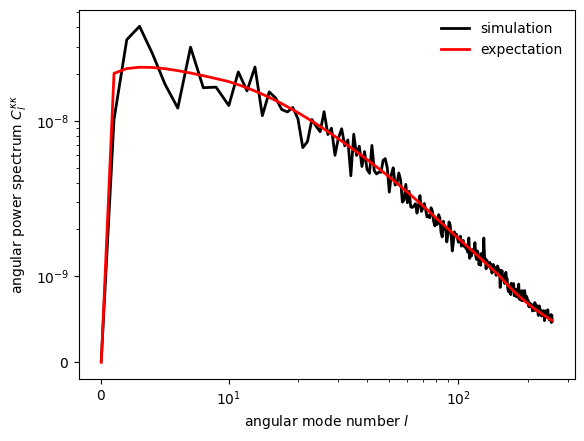

In [ ]:
# get the angular power spectra of the lensing maps
sim_cls = hp.anafast(
    [kappa_bar, gamm1_bar, gamm2_bar],
    pol=True,
    lmax=lmax,
    use_pixel_weights=True,
)

# get the expected cls from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type="lensing"),
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

# get the HEALPix pixel window function, since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

# plot the realised and expected cls
ell = np.arange(lmax + 1)
plt.plot(ell, sim_cls[0], "-k", lw=2, label="simulation")
plt.plot(ell, theory_cls["W1xW1"] * pw**2, "-r", lw=2, label="expectation")
plt.xscale("symlog", linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale("symlog", linthresh=1e-9, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel(r"angular mode number $l$")
plt.ylabel(r"angular power spectrum $C_l^{\kappa\kappa}$")
plt.legend(frameon=False)
plt.show()